In [1]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

/Users/ips/Documents/trail/AI Agents/aiagent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [3]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [6]:
search = DuckDuckGoSearchRun()

search.invoke("who is a current president of USA?")





"The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of ... As the head of the government of the United States, the president is arguably the most powerful government official in the world. The president is elected to a four-year term via an electoral college system. Since the Twenty-second Amendment was adopted in 1951, the American presidency has been limited to a maximum of two terms.. Click on a president below to learn more about each presidency ... The president of the United States is the: U.S. head of state; Chief executive of the federal government; Commander-in-Chief of the armed forces; Current president. The 47th and current president of t

In [7]:
tools = [add, multiply, divide, search]

llm_with_tools=llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
  

def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

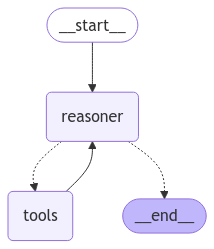

In [8]:

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()


# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]


messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (c0ea4e99-8691-4f54-9bb5-23492438534f)
 Call ID: c0ea4e99-8691-4f54-9bb5-23492438534f
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi is the prime minister of India since 2014 and a leader of the BJP. He was born on September 17, 1950, in Vadnagar, India, and is a member of the RSS. Learn about the life and achievements of Narendra Modi, the current Prime Minister of India, who was born on September 17, 1950, in Gujarat. Find out his full name, education, political journey, and role in the BJP and RSS. List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. Jaw

In [11]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]
     

messages = react_graph.invoke({"messages": messages})


for m in messages['messages']:
    m.pretty_print()
     

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (4b988819-7aed-40b1-8efb-24c39eb99fac)
 Call ID: 4b988819-7aed-40b1-8efb-24c39eb99fac
  Args:
    query: current age of Elon Musk
================================= Tool Message =================================
Name: duckduckgo_search

#1 Elon Musk on the 2024 Forbes 400 #1 Elon Musk on the 2024 Forbes 400. Subscribe To Newsletters. ... Age 53 Source of Wealth Tesla, SpaceX, Self Made Self-Made Score 8 Philanthropy Score 1 On Jan. 4, 2024, Musk's mother, Maye Musk, spoke of her 12-year difficulties obtaining U.S. citizenship as a Canadian citizen, responding to a comment from her son on the X platform.. His early ... Elon Musk is founder of Tesla Motors and SpaceX among other companies. Read about his net worth, children

In [13]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [14]:
get_stock_price("AAPL")

240.36

In [15]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}



tools = [add, multiply, divide, search, get_stock_price]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
## we can use the messagestate instead of manual creating like below
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

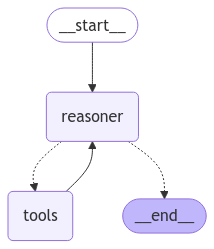

In [17]:

# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [18]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})
     
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (7642c85b-09e6-4101-b63c-1ca53445744e)
 Call ID: 7642c85b-09e6-4101-b63c-1ca53445744e
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

240.36
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  add (61f3cc14-5d95-4c93-a5b3-8988698e80dc)
 Call ID: 61f3cc14-5d95-4c93-a5b3-8988698e80dc
  Args:
    a: 240.0
    b: 1000.0
================================= Tool Message =================================
Name: add

1240
================================ Human Message =================================

What is the stock 